##  Mount Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  Importing The Required Libraries=>

In [2]:
# Import required libraries
import os
import random
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pandas as pd

In [3]:
# TensorFlow/Keras imports
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

# === Step 1: Defining directories ===>

In [4]:
# === Step 1: Define directories ===
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI Images/Training/'
test_dir = '/content/drive/MyDrive/MRI Images/Testing/'

# === Step 2: Loading image paths and labels ===>

In [5]:
# === Step 2: Load image paths and labels ===
def get_image_data(directory):
    paths, labels = [], []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        for img in os.listdir(class_path):
            paths.append(os.path.join(class_path, img))
            labels.append(class_name)
    return shuffle(paths, labels)

train_image_paths, train_image_labels = get_image_data(train_dir)
test_image_paths, test_image_labels = get_image_data(test_dir)

# === Step 3: Generating summary table ===>

In [6]:
# === Step 3: Generate summary table ===
train_count = pd.DataFrame.from_dict(Counter(train_image_labels), orient='index', columns=['Train Count'])
test_count = pd.DataFrame.from_dict(Counter(test_image_labels), orient='index', columns=['Test Count'])

summary_df = pd.concat([train_count, test_count], axis=1).fillna(0).astype(int)
summary_df.index.name = 'Tumor Type'

print("\n>>> Summary Table:")
print(summary_df)


>>> Summary Table:
            Train Count  Test Count
Tumor Type                         
pituitary          1457         300
glioma             1321         300
meningioma         1339         306
notumor            1605         405


# === Step 4: Displaying table as a heatmap ===>

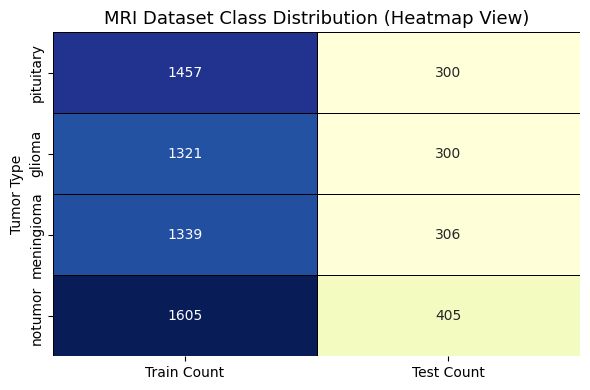

In [7]:
# === Step 4: Display table as a heatmap ===
plt.figure(figsize=(6, 4))
sns.heatmap(summary_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False, linewidths=0.7, linecolor='black')
plt.title("MRI Dataset Class Distribution (Heatmap View)", fontsize=13)
plt.tight_layout()
plt.show()

# === Step 5: Pie charts for train and test distributions ===>

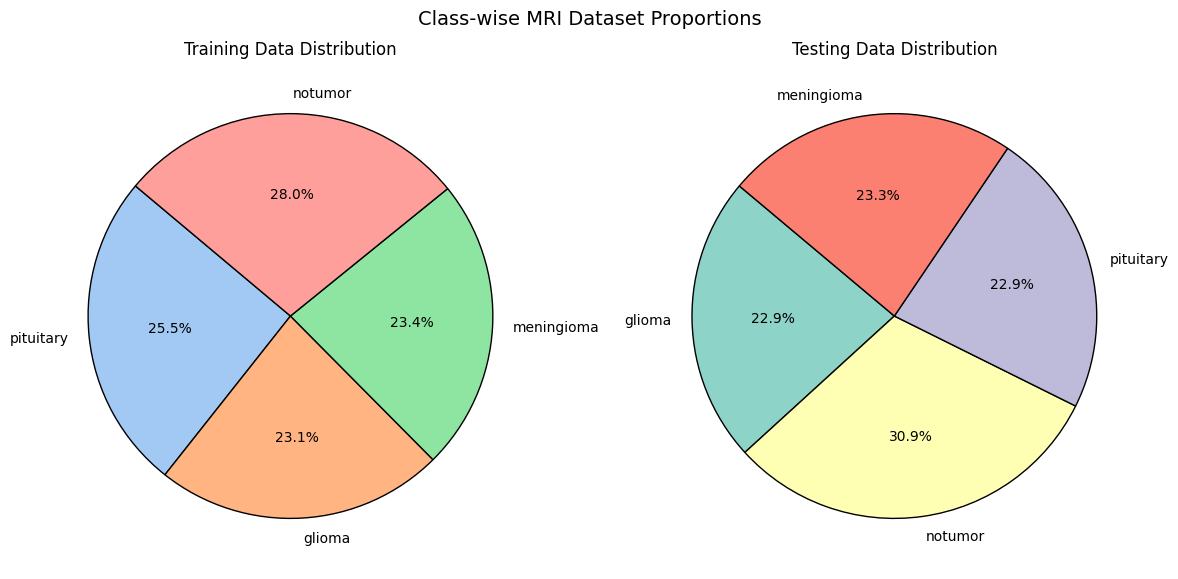

In [8]:

# === Step 5: Pie charts for train and test distributions ===
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Train pie
ax[0].pie(train_count['Train Count'], labels=train_count.index, autopct='%1.1f%%', startangle=140,
          colors=sns.color_palette("pastel"), wedgeprops={'edgecolor': 'black'})
ax[0].set_title("Training Data Distribution")

# Test pie
ax[1].pie(test_count['Test Count'], labels=test_count.index, autopct='%1.1f%%', startangle=140,
          colors=sns.color_palette("Set3"), wedgeprops={'edgecolor': 'black'})
ax[1].set_title("Testing Data Distribution")

plt.suptitle("Class-wise MRI Dataset Proportions", fontsize=14)
plt.tight_layout()
plt.show()

# === Step 6: Visualizing the sample images ===>

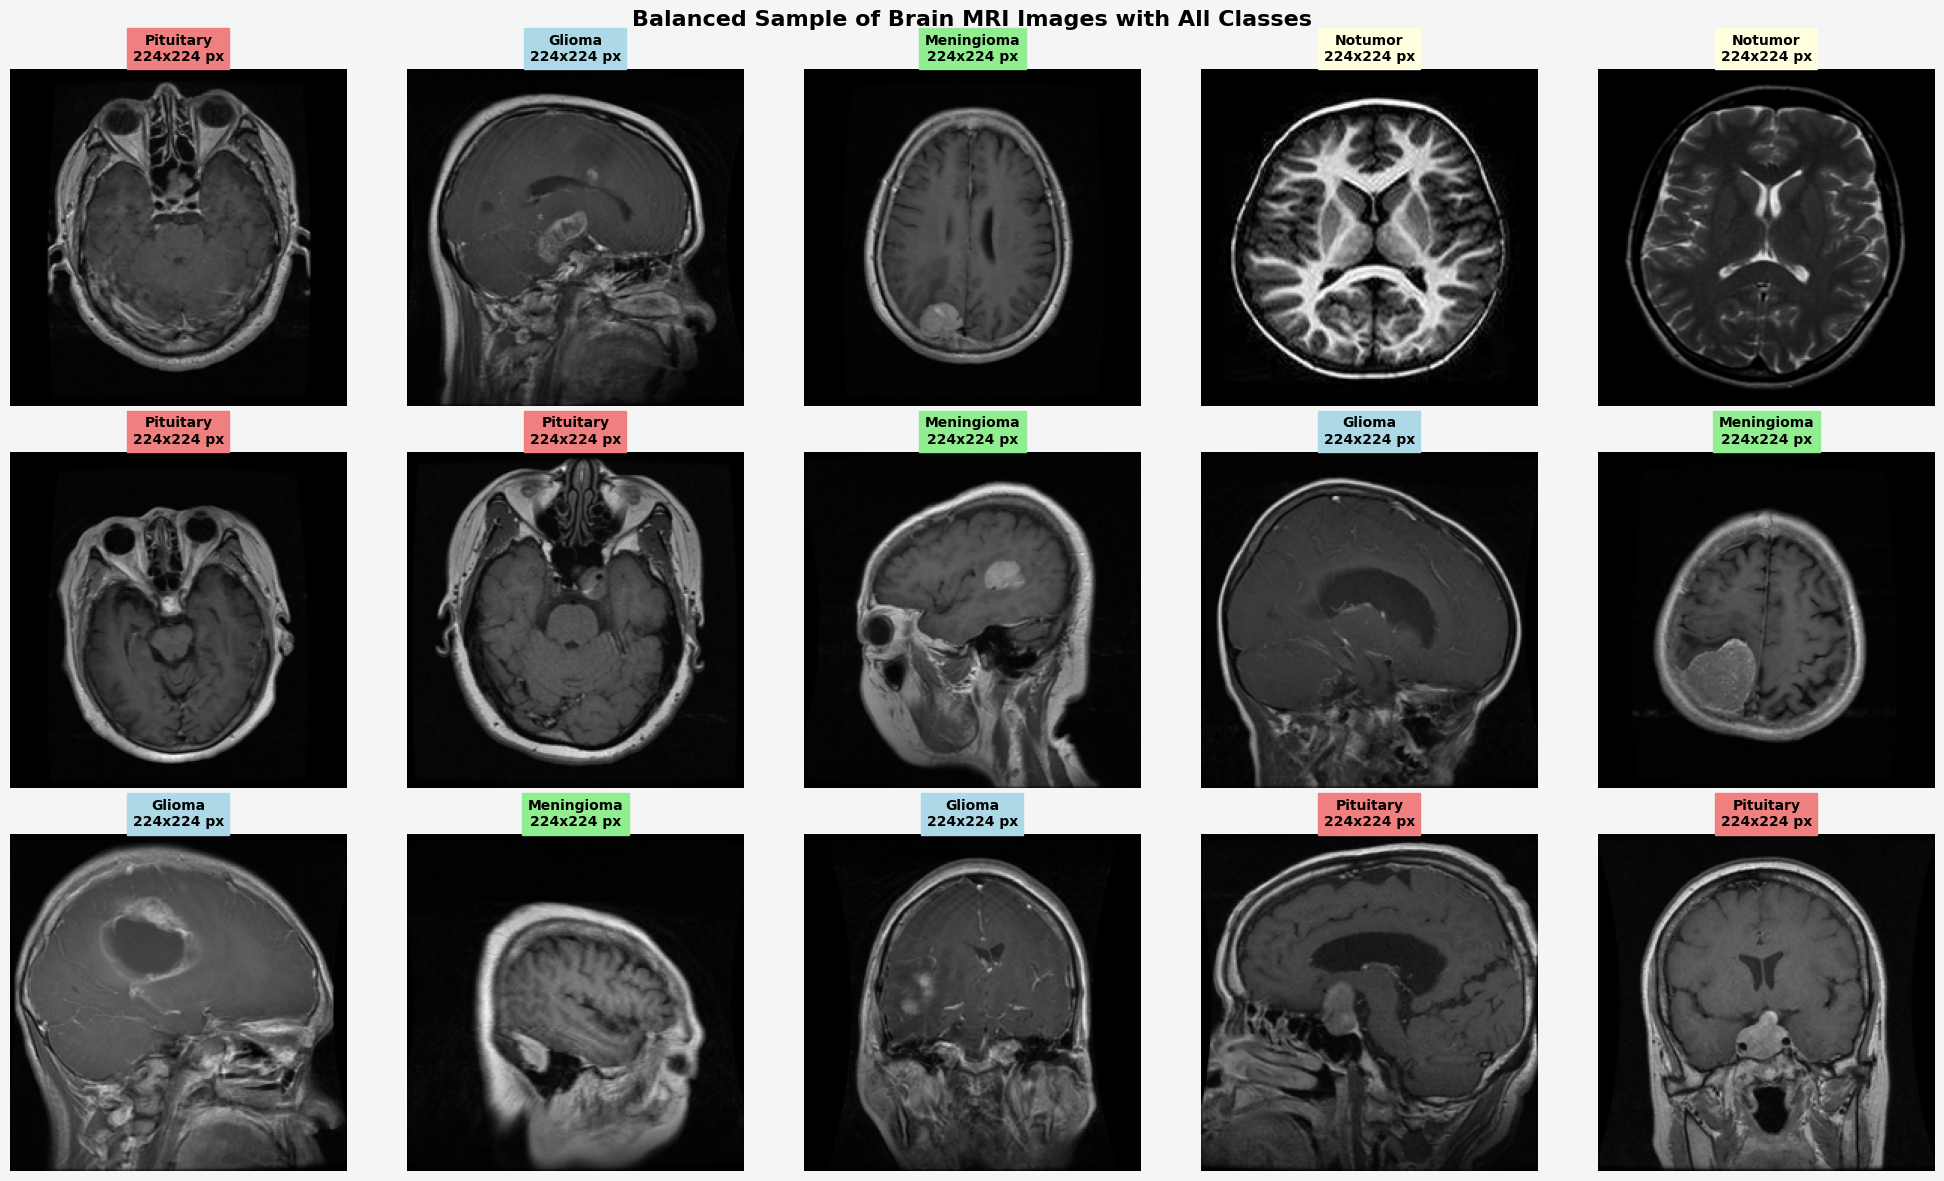

In [9]:
# === Step 6: Visualize sample images ===
# Define colors for different classes
label_colors = {
    'glioma': 'lightblue',
    'meningioma': 'lightgreen',
    'pituitary': 'lightcoral',
    'notumor': 'lightyellow'
}

# First, group images by class
classwise_images = defaultdict(list)
for path, label in zip(train_image_paths, train_image_labels):
    classwise_images[label.lower()].append(path)

# Ensure 1 image from each class is selected
selected_paths = []
selected_labels = []
for label in classwise_images:
    if classwise_images[label]:  # Ensure non-empty
        img_path = random.choice(classwise_images[label])
        selected_paths.append(img_path)
        selected_labels.append(label)

# Select remaining random images (15 - already selected)
remaining_count = 15 - len(selected_paths)
all_remaining = [(p, l) for p, l in zip(train_image_paths, train_image_labels)
                 if p not in selected_paths]
extra_samples = random.sample(all_remaining, remaining_count)

# Add the extras
for p, l in extra_samples:
    selected_paths.append(p)
    selected_labels.append(l.lower())

# Now display the 15 images
fig, axes = plt.subplots(3, 5, figsize=(20, 12), facecolor='whitesmoke')
axes = axes.ravel()

for i in range(15):
    try:
        img_path = selected_paths[i]
        img = Image.open(img_path).convert('RGB')
        img = img.resize((224, 224))

        label = selected_labels[i]
        label_clean = label.lower()

        # Display image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{label.capitalize()}\n{img.size[0]}x{img.size[1]} px", fontsize=10,
                          backgroundcolor=label_colors.get(label_clean, 'lightyellow'),
                          fontweight='bold')

        # Set border color
        for spine in axes[i].spines.values():
            spine.set_edgecolor(label_colors.get(label_clean, 'gold'))
            spine.set_linewidth(3)

    except:
        axes[i].axis('off')
        axes[i].set_title("Unreadable Image", fontsize=9, color='red')

plt.suptitle("Balanced Sample of Brain MRI Images with All Classes", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# === Step 7: Defining image augmentation and preprocessing ===>

In [10]:
# === Step 7: Define image augmentation and preprocessing ===
IMAGE_SIZE = 128  # Define image size for model input

# Enhance image brightness and contrast, then normalize
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    return np.array(image) / 255.0

# Load and preprocess images
def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        images.append(augment_image(img))
    return np.array(images)

# Convert string labels to integers
def encode_label(labels):
    classes = os.listdir(train_dir)
    return np.array([classes.index(label) for label in labels])

# Yield batches of augmented image-label pairs
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            x_batch = open_images(paths[i:i + batch_size])
            y_batch = encode_label(labels[i:i + batch_size])
            yield x_batch, y_batch


# Step 8: Architecture Of The Model (Model Traiing, Epochs=5)=>

In [11]:
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 25
steps = int(len(train_image_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_image_paths, train_image_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 1365s 6s/step - loss: 0.6751 - sparse_categorical_accuracy: 0.7303
Epoch 2/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - loss: 0.2539 - sparse_categorical_accuracy: 0.8996
Epoch 3/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.9375
Epoch 4/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - loss: 0.1160 - sparse_categorical_accuracy: 0.9565
Epoch 5/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 30s 131ms/step - loss: 0.0851 - sparse_categorical_accuracy: 0.9708


# Step 9: Plots Of Accuracy Vs Epochs and Loss Vs Epochs=>

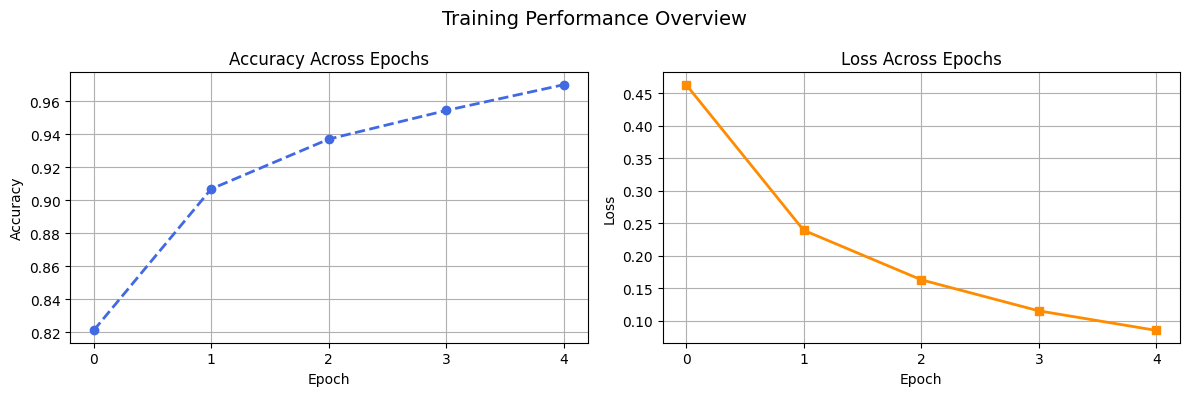

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# Accuracy plot
axes[0].plot(history.history['sparse_categorical_accuracy'], color='royalblue', marker='o', linestyle='--', linewidth=2)
axes[0].set_title('Accuracy Across Epochs', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)
axes[0].set_xticks(range(epochs))

# Loss plot
axes[1].plot(history.history['loss'], color='darkorange', marker='s', linestyle='-', linewidth=2)
axes[1].set_title('Loss Across Epochs', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)
axes[1].set_xticks(range(epochs))

plt.suptitle('Training Performance Overview', fontsize=14)
plt.tight_layout()
plt.show()


# Step 10: Report of the Classification & Class-wise F1 Score is as follows =>

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 208ms/step

 Classification Report:
              precision    recall  f1-score      support
glioma         1.000000  0.983333  0.991597   300.000000
meningioma     0.959559  0.870000  0.912587   300.000000
pituitary      0.881818  0.950980  0.915094   306.000000
notumor        0.978261  1.000000  0.989011   405.000000
accuracy       0.954996  0.954996  0.954996     0.954996
macro avg      0.954909  0.951078  0.952072  1311.000000
weighted avg   0.956445  0.954996  0.954862  1311.000000


<ipython-input-13-6d8af5d0b443>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index[:-3], y=report_df['f1-score'][:-3], palette="viridis")


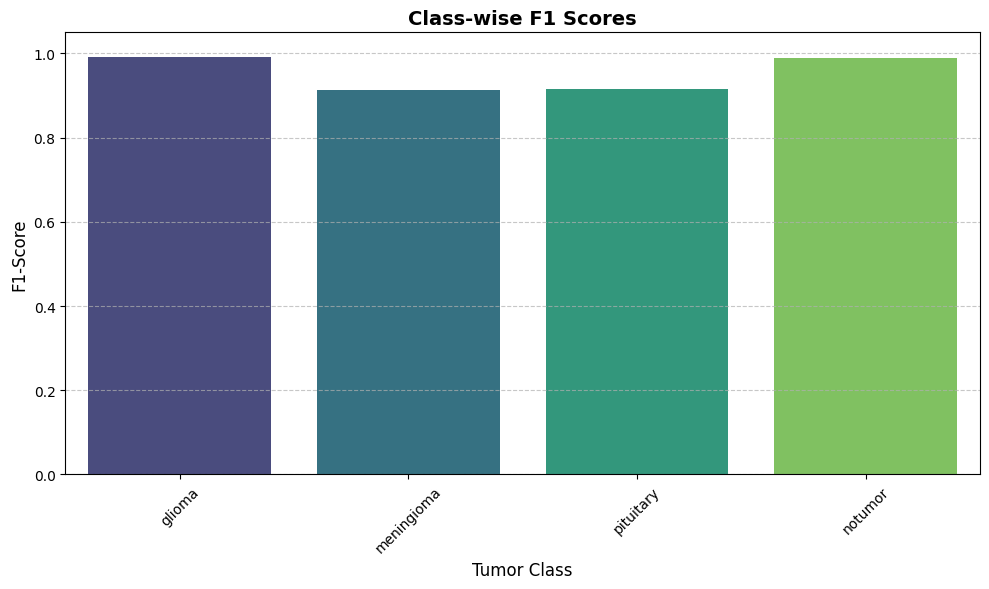

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np
import pandas as pd

# === Step X: Generate Predictions on Test Data ===
test_images_processed = open_images(test_image_paths)                   # Load + preprocess test images
test_labels_encoded = encode_label(test_image_labels)                  # Encode true labels
test_predictions = model.predict(test_images_processed)                # Run model predictions

# === Step Y: Classification Report ===
print("\n Classification Report:")
report = classification_report(test_labels_encoded,
                               np.argmax(test_predictions, axis=1),
                               target_names=list(set(train_image_labels)),  # Ensure class names
                               output_dict=True)

# Convert to DataFrame for neat display
report_df = pd.DataFrame(report).transpose()
print(report_df)

# === Step Z: Visualize F1-Score Per Class ===
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index[:-3], y=report_df['f1-score'][:-3], palette="viridis")
plt.title("Class-wise F1 Scores", fontsize=14, weight='bold')
plt.xlabel("Tumor Class", fontsize=12)
plt.ylabel("F1-Score", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Step 11: Confusion Matrix Display =>

Confusion Matrix:
[[295   1   3   1]
 [  0 261  36   3]
 [  0  10 291   5]
 [  0   0   0 405]]


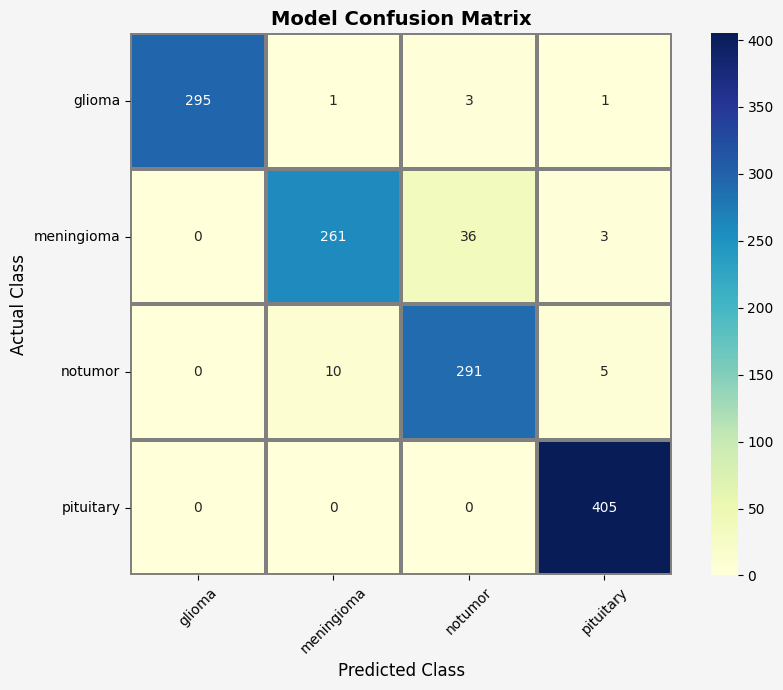

In [14]:
# === Step 3: Confusion Matrix Display ===
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Define custom class names from training directory (sorted for consistency)
class_names = sorted(os.listdir(train_dir))

# Plot with enhanced aesthetics
plt.figure(figsize=(9, 7), facecolor='whitesmoke')
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_names, yticklabels=class_names,
            linewidths=1.5, linecolor='gray', cbar=True, square=True)

plt.title("Model Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Step 12: ROC Curve and AUC Display =>

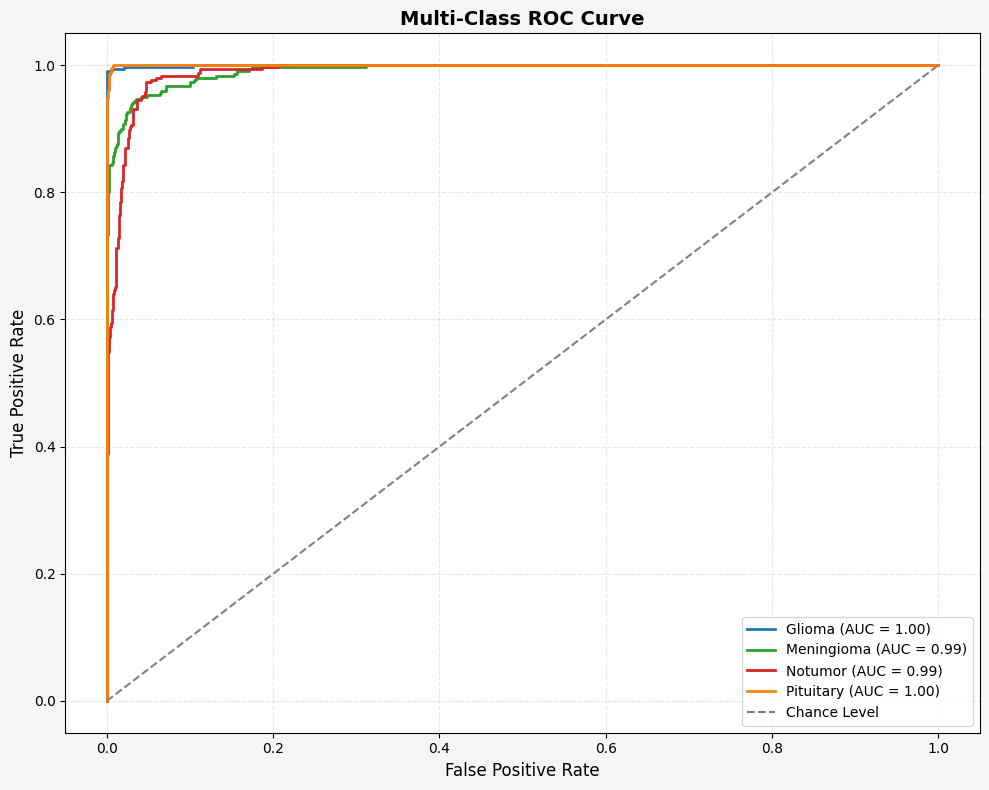

In [15]:
# === Step 4: ROC Curve and AUC ===
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the test labels and predictions for multi-class ROC
class_names = sorted(os.listdir(train_dir))
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(class_names)))
test_predictions_bin = test_predictions  # Already in probability format

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define color palette for better distinction
roc_colors = ['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e']  # Add more if needed

# Plot ROC curves
plt.figure(figsize=(10, 8), facecolor='whitesmoke')
for i, class_name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], color=roc_colors[i % len(roc_colors)],
             label=f"{class_name.capitalize()} (AUC = {roc_auc[i]:.2f})", linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance Level')  # Diagonal baseline
plt.title("Multi-Class ROC Curve", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Step 13: Saving + Loading the Model=>

In [16]:
# Save the entire model
model.save('model.h5')

In [17]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

# Step 14: Model Made ready for use=>

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# Custom class names
tumor_categories = ['pituitary', 'glioma','meningioma', 'notumor' ]

def tumor_prediction_viewer(path_to_image, trained_model, target_dim=128, threshold=0.6):
    """
    This function processes a given brain MRI image, makes a prediction using the supplied model,
    and visually displays the image along with the diagnostic outcome and confidence score.
    If prediction confidence is low, it displays a caution note.
    """
    try:
        # Step 1: Load and resize image
        original_img = load_img(path_to_image, target_size=(target_dim, target_dim))
        processed_img = img_to_array(original_img) / 255.0
        processed_img = np.expand_dims(processed_img, axis=0)

        print(f"Input Image Shape: {processed_img.shape}")

        # Step 2: Generate prediction
        prob_vector = trained_model.predict(processed_img)
        predicted_idx = np.argmax(prob_vector)
        prediction_score = prob_vector[0][predicted_idx]

        # Step 3: Construct prediction message
        predicted_label = tumor_categories[predicted_idx]

        # Fix: Adjust logic to ensure correct label display
        if predicted_label == 'notumor':
            message = "✔️ MRI shows no signs of tumor."
        elif predicted_label == 'meningioma':
            message = f"⚠️ Likely: {predicted_label.capitalize()} Tumor"
        else:
            message = f"⚠️ Likely: {predicted_label.capitalize()} Tumor"

        # Step 4: Display with confidence
        plt.figure(figsize=(6, 6))
        plt.imshow(original_img)
        plt.axis('off')
        title_color = 'green' if predicted_label == 'notumor' else 'red'

        if prediction_score < threshold:
            message += f"\n(Note: Low Confidence - {prediction_score*100:.2f}%)"
            title_color = 'orange'
        else:
            message += f"\nConfidence: {prediction_score*100:.2f}%"

        plt.title(message, fontsize=11, color=title_color, weight='bold')
        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"🚫 File not found at path: {path_to_image}")
    except Exception as e:
        print(f"❌ An unexpected error occurred: {str(e)}")


# Step 15: Sample Testing the Model's Accuracy =>

Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


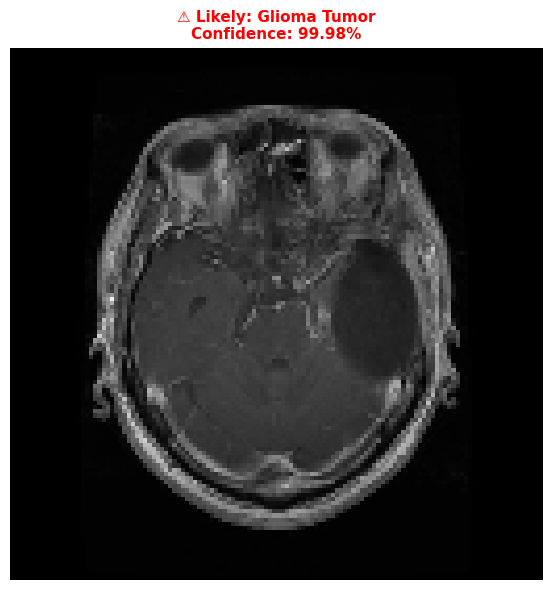

In [40]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0015.jpg'  # Update path as needed
tumor_prediction_viewer(image_path, model)


Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


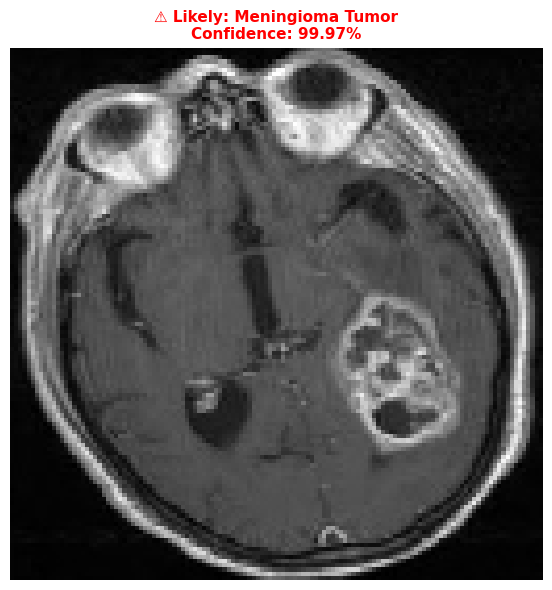

In [37]:
# Example usage with a test image from the Meningioma class
image_path = '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'
tumor_prediction_viewer(image_path, model)


Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


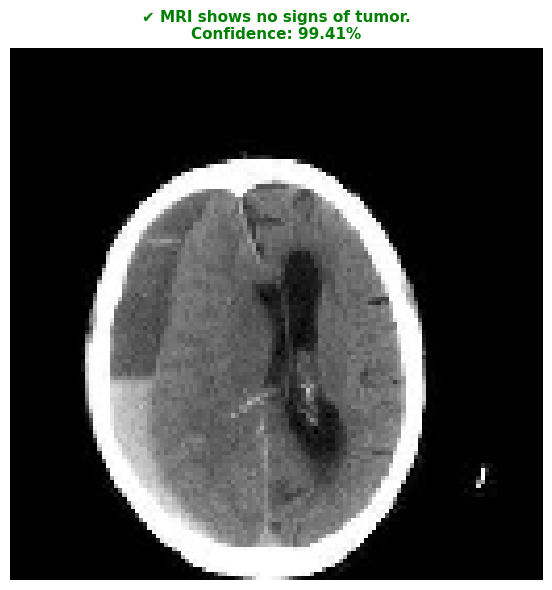

In [38]:
# Example usage with a test image from the No Tumor class
image_path = '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-noTr_0000.jpg'
tumor_prediction_viewer(image_path, model)


Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


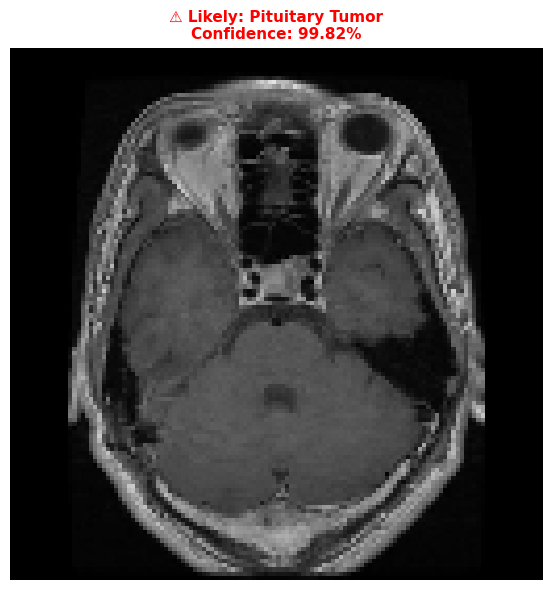

In [39]:
# Example usage with a test image from the Pituitary Tumor class
image_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-piTr_0000.jpg'
tumor_prediction_viewer(image_path, model)

Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


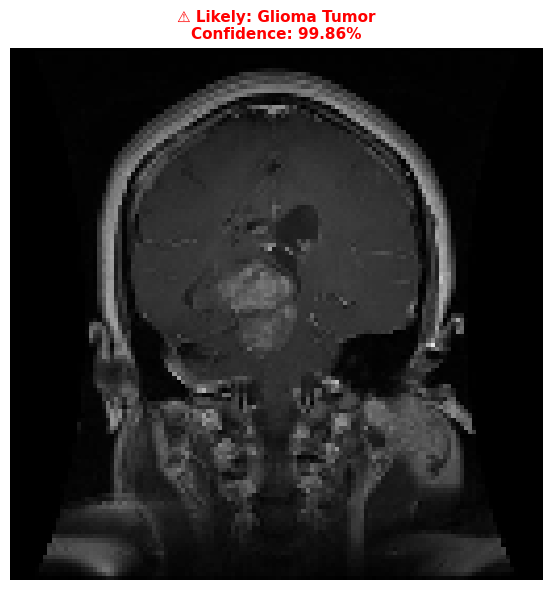

In [41]:
# Example usage with a test image from the Pituitary Tumor class
image_path = '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0143.jpg'
tumor_prediction_viewer(image_path, model)

Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


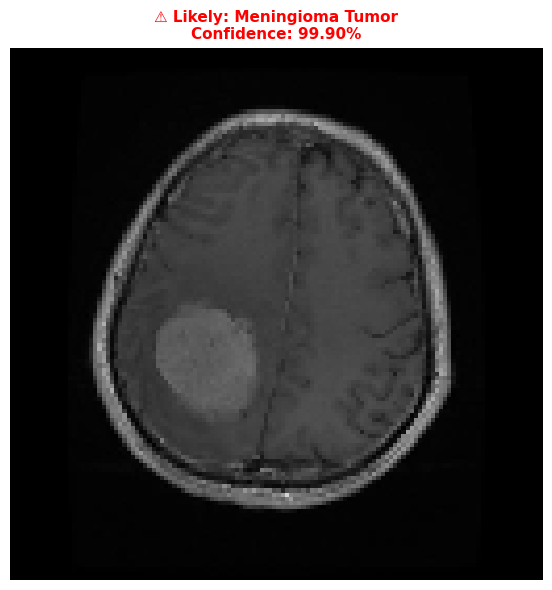

In [42]:
# Example usage with a test image from the Pituitary Tumor class
image_path = '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-me_0138.jpg'
tumor_prediction_viewer(image_path, model)

Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


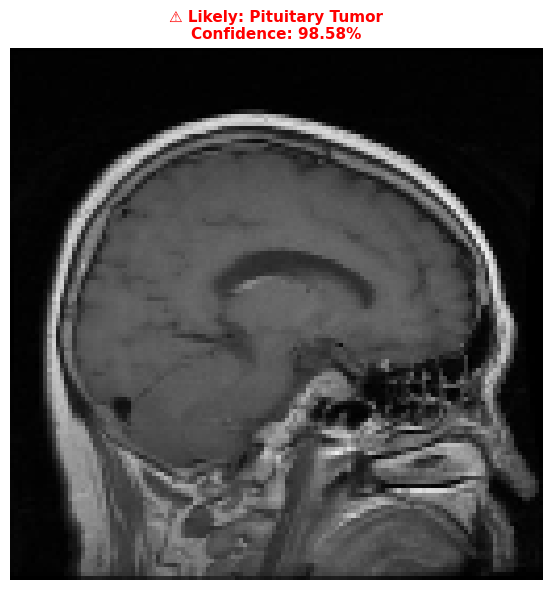

In [43]:
# Example usage with a test image from the Pituitary Tumor class
image_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-pi_0291.jpg'
tumor_prediction_viewer(image_path, model)

Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


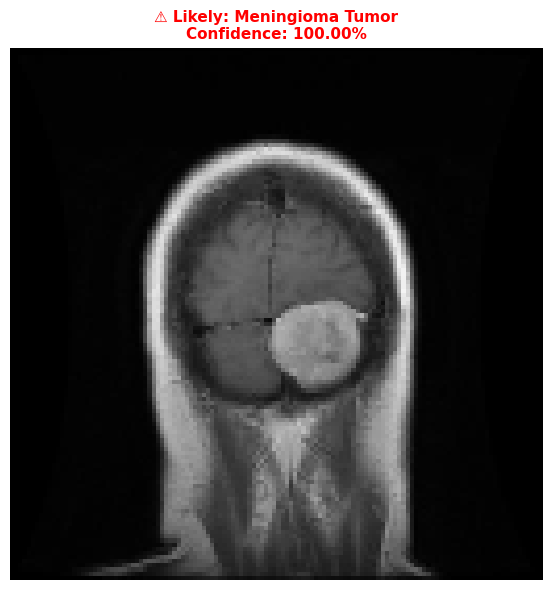

In [44]:
# Example usage with a test image from the Pituitary Tumor class
image_path = '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-me_0210.jpg'
tumor_prediction_viewer(image_path, model)

Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


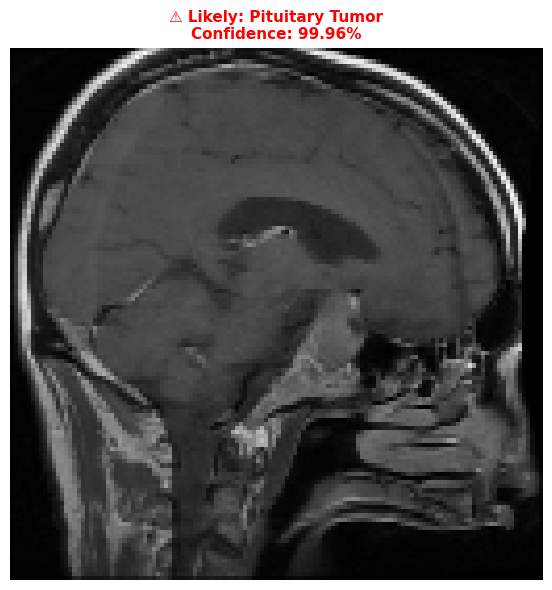

In [45]:
# Example usage with a test image from the Pituitary Tumor class
image_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-pi_0256.jpg'
tumor_prediction_viewer(image_path, model)

Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


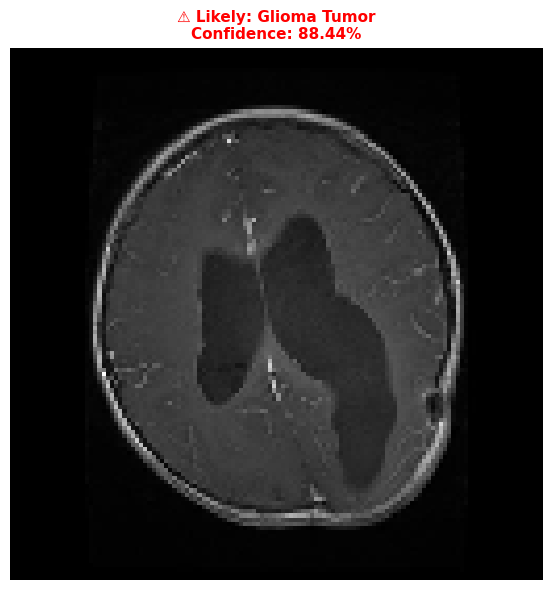

In [46]:
# Example usage with a test image from the Pituitary Tumor class
image_path = '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0105.jpg'
tumor_prediction_viewer(image_path, model)

Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


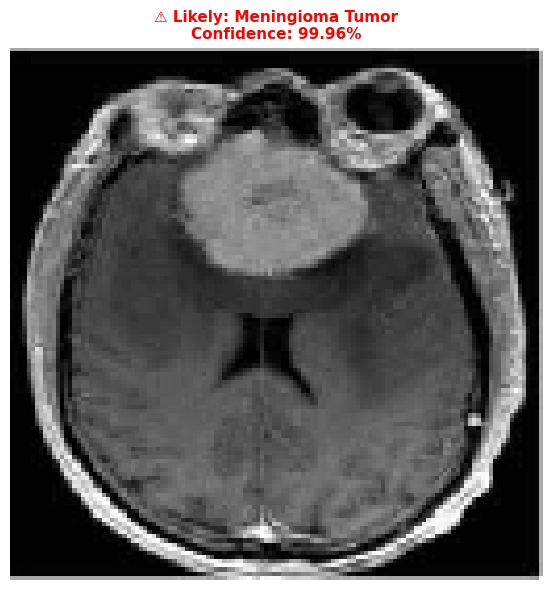

In [47]:
# Example usage with a test image from the Pituitary Tumor class
image_path = '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-me_0097.jpg'
tumor_prediction_viewer(image_path, model)

Input Image Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


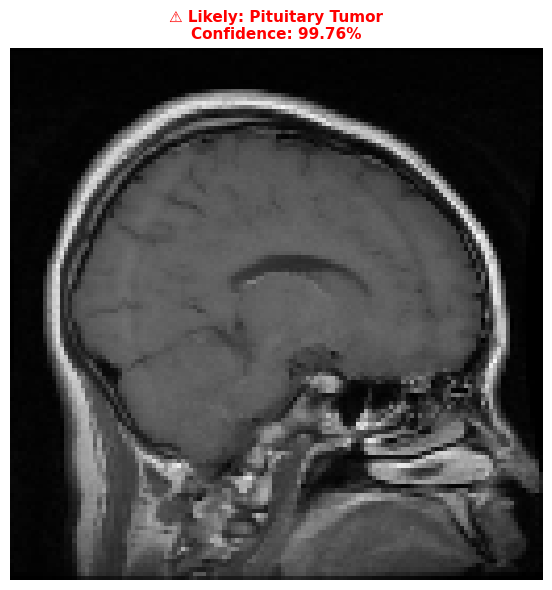

In [48]:
# Example usage with a test image from the Pituitary Tumor class
image_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-pi_0285.jpg'
tumor_prediction_viewer(image_path, model)